# Kaggle Competition: Titanic survival
### Victor Ambonati (Vicam)
### 20 November 2016

# 1 Introduction
Notebook inspired of "Exploring Survival on Titanic" by Megan Risdal, a Kernel in R on Kaggle: https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic
I make my debut on Kaggle and I'm new to Data Science. I'm hoping to learn a lot so your comments and suggestions are welcomed.  
## 1.1 Load and check data

In [474]:
# Load library
%matplotlib inline
import pandas as pd
import numpy as np
import csv as csv 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Get the raw data
train_df = pd.read_csv('train.csv', header=0)
test_df = pd.read_csv('test.csv', header=0)
full_df = pd.concat([train_df, test_df]) #Bind training and test data

#check data
# print(full_df.head(5))
print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB
None


We can tell that there is 1309 observations of 12 features. And some data are missing. Here is a better description of the feature:

Variable Name | Description
--------------|-------------
Survived      | Survived (1) or died (0)
Pclass        | Passenger's class
Name          | Passenger's name
Sex           | Passenger's sex
Age           | Passenger's age
SibSp         | Number of siblings/spouses aboard
Parch         | Number of parents/children aboard
Ticket        | Ticket number
Fare          | Fare
Cabin         | Cabin
Embarked      | Port of embarkation

# 2 Feature Engineering
## 2.1 Survived
This is the feature we want to predict on our test set. We won't modify it.
## 2.2 Pclass
No missing value. Already numeric value. Let's see if it seems to have an impact on survival.

In [475]:
# Survival rate depending on passenger's class
print( full_df[["Pclass", "Survived"]].groupby(['Pclass'],as_index=False).mean() )

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


Great ! We can see a relation here. People with class 1 ticket seem to have a better survival than those with class 3 ticket. I will not change this variable.
## 2.3 Name
In the name feature, we can find the first name, the last name but also the Title. May be the Title of the person can be helpful.

In [476]:
full_df['Title'] = full_df['Name'].str.replace('(.*, )|(\\..*)', '') # creation of a new feature "Title" in the dataframe

# These line help me to find out a problem, there was Miss with male sex. 
# I correct the mistake but I let those lines to show how I found.
    #print (full_df.groupby(['Title','Sex']).size())
    #print(pd.crosstab(full_df['Title'],full_df['Sex']))
    #print( full_df[(full_df['Title'] == 'Miss') & (full_df['Sex'] == 'male')].head(3))

print(pd.crosstab(full_df['Title'],full_df['Sex']))

Sex           female  male
Title                     
Capt               0     1
Col                0     4
Don                0     1
Dona               1     0
Dr                 1     7
Jonkheer           0     1
Lady               1     0
Major              0     2
Master             0    61
Miss             260     0
Mlle               2     0
Mme                1     0
Mr                 0   757
Mrs              197     0
Ms                 2     0
Rev                0     8
Sir                0     1
the Countess       1     0


In [477]:
# We can see there is Title with few counts, we will group them into special title
full_df['Title'] = full_df['Title'].replace(['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'special_title')

# Also reassign mlle, ms, and mme accordingly
full_df['Title'] = full_df['Title'].replace('Mlle', 'Miss')
full_df['Title'] = full_df['Title'].replace('Ms', 'Miss')
full_df['Title'] = full_df['Title'].replace('Mme', 'Mrs')

# Relation between Title, sex and survival rate.
print( full_df[["Title","Sex", "Survived"]].groupby(['Title', 'Sex'],as_index=False).mean() )

#create a similar feature but a numeric feature for the learning algorihm
full_df['Title_Num'] = full_df['Title'].map( {'Mrs': 0, 'Miss': 1, 'special_title':2, 'Master':3, 'Mr':4} ).astype(int) 

           Title     Sex  Survived
0         Master    male  0.575000
1           Miss  female  0.702703
2             Mr    male  0.156673
3            Mrs  female  0.793651
4  special_title  female  1.000000
5  special_title    male  0.250000


The Title seem to have a good correlation with the survival. We know from the first exercise that Sex is a good feature. Since Title is link to Sex, we have also good correlation. But the Title still seem to add informations, Master title are male with good Survival rate for example. So let's keep this new feature and search for another new feature.
## 2.4 Sex

In [478]:
print( full_df[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean() )
#transform Sex into numeric feature for the learning algorithm
full_df['Gender'] = full_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int) 

      Sex  Survived
0  female  0.742038
1    male  0.188908


Sex is indeed a feature with high correlation with Survival. We will may be use it to create new feature after.
## 2.5 SibSp and Parch
With the number of siblings/spouse and number of children/parents we can create a variable FamilySize. And let's see if the size of the family have an impact on the survival.

In [479]:
# Create a new feature: family size (including the passenger themselves)
full_df['FamilySize'] = full_df['SibSp'] + full_df['Parch'] + 1
cor_FSize = full_df[["FamilySize", "Survived"]].groupby(['FamilySize'],as_index=False).mean()
print(cor_FSize)
    #plt.bar(cor_FSize['FamilySize'], cor_FSize['Survived'])
    #plt.xlabel('Family Size')
    #plt.ylabel('Survival Rate')

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


Interesting ! We can see that single person and big family (above 4 members) have survival penalty. Let's create a Family Size Categories variable with singleton, small and large family categories.

In [480]:
full_df['FamilySizeCategories'] = full_df['FamilySize']
full_df.loc[ full_df['FamilySizeCategories'] == 1, 'FamilySizeCategories' ] = 0 #Singleton
full_df.loc[ (full_df['FamilySizeCategories'] > 1) & (full_df['FamilySizeCategories'] < 5) , 'FamilySizeCategories' ] = 1 #Small
full_df.loc[ full_df['FamilySizeCategories'] > 4, 'FamilySizeCategories' ] = 2 #Large
print( full_df[["FamilySizeCategories", "Survived"]].groupby(['FamilySizeCategories'],as_index=False).mean() )

   FamilySizeCategories  Survived
0                     0  0.303538
1                     1  0.578767
2                     2  0.161290


Looks good. Let's see what we can do next.
## 2.6 Ticket, Cabin, Fare, Embarked
I have no special idea for Ticket feature. I will put it aside for now.
Same for Cabin, and there is a lot of missing value for Cabin.
There is one missing value for Fare, let's replace it by the median of Ticket feature.
And let's complete missing value of Embarked feature too.

In [481]:
# replace missing value of Fare
full_df.loc[ full_df['Fare'].isnull(), 'Fare' ] = full_df['Fare'].mean()
#transform Embarked into numeric value for the learning algorithm
full_df['Embarked_Num'] = full_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )
# fill the 3 missing values
full_df.loc[ full_df['Embarked'].isnull(), 'Embarked_Num' ] = 1

## 2.7 Age
We have missing value for this feature (1046/1309). Let's try to fill them correctly.

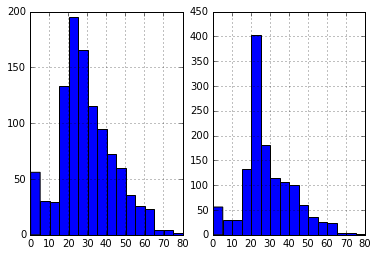

In [482]:
# Keep track of what was he missing value
full_df['AgeIsNull'] = pd.isnull(full_df.Age).astype(int)

#Fill the missing value with the median value of people having same class and gender.
full_df['AgeFill'] = full_df['Age']
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = full_df[(full_df['Gender'] == i) & \
                              (full_df['Pclass'] == j+1)]['Age'].dropna().median()
        full_df.loc[ (full_df.Age.isnull()) & (full_df.Gender == i) & (full_df.Pclass == j+1),\
         'AgeFill'] = median_ages[i,j]

# plot old Age and new Age values
fig, axs = plt.subplots(1,2)
full_df['Age'][~np.isnan(full_df['Age'])].hist(ax=axs[0], bins=16)
full_df['AgeFill'].hist(ax=axs[1], bins=16)

Hmmmm... It doesn't look the same at all. Our repartition seem too rough. So, we will try with another method.

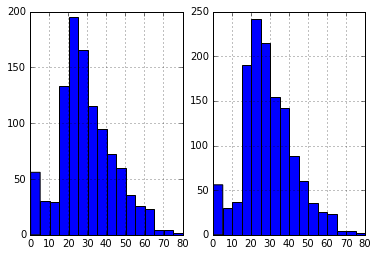

In [483]:
# get average, std, and number of NaN values
average_age_titanic   = full_df["Age"].mean()
std_age_titanic       = full_df["Age"].std()
count_nan_age_titanic = full_df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + 
                           std_age_titanic, size = count_nan_age_titanic)

# fill NaN values in Age column with random values generated
full_df.loc[np.isnan(full_df["Age"]), "AgeFill"] = rand_1

# plot old Age and new Age values
fig, axs = plt.subplots(1,2)
full_df['Age'][~np.isnan(full_df['Age'])].hist(ax=axs[0], bins=16)
full_df['AgeFill'].hist(ax=axs[1], bins=16)

Ahhh ! This method seems better because the repartition seems similar this time.
Let's create new feature with Age: Child.

In [484]:
full_df['Child'] = (full_df['Age'] < 18).astype(int)
print( full_df[["Child", "Sex", "Survived"]].groupby(['Child', 'Sex'],as_index=False).mean() )

   Child     Sex  Survived
0      0  female  0.752896
1      0    male  0.165703
2      1  female  0.690909
3      1    male  0.396552


Being a child doesn't help as much as being a women, but it helps !
Let's create another new feature: Mother

In [485]:
full_df['Mother'] = ((full_df['Gender'] == 0) & (full_df['AgeFill'] > 18) & (full_df['Title'] == "Miss")).astype(int)
print( full_df[["Mother", "Survived"]].groupby(['Mother'],as_index=False).mean() )
print( full_df[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean() )

   Mother  Survived
0       0  0.332041
1       1  0.726496
      Sex  Survived
0  female  0.742038
1    male  0.188908


It helps to be a Mother, but it doesn't change much compared to other women.

# 3 Prediction
Now, we have all the features we need, we will clean the non necessary data, choose our model and check the results.
## 3.1 Data Cleaning
We will remove the non numeric column and not complete column.

In [486]:
print (full_df.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 22 columns):
Age                     1046 non-null float64
Cabin                   295 non-null object
Embarked                1307 non-null object
Fare                    1309 non-null float64
Name                    1309 non-null object
Parch                   1309 non-null int64
PassengerId             1309 non-null int64
Pclass                  1309 non-null int64
Sex                     1309 non-null object
SibSp                   1309 non-null int64
Survived                891 non-null float64
Ticket                  1309 non-null object
Title                   1309 non-null object
Title_Num               1309 non-null int32
Gender                  1309 non-null int32
FamilySize              1309 non-null int64
FamilySizeCategories    1309 non-null int64
Embarked_Num            1309 non-null float64
AgeIsNull               1309 non-null int32
AgeFill                 1309 non-null float64


In [487]:
full_df = full_df.drop(['Age', 'Cabin', 'Embarked', 'Name', 'Sex', 'Ticket', 'Title', 'AgeIsNull'], axis=1)

## 3.2 Choosing the model
We will just try the logistic regression and random forest. The other models give me less good result.

In [488]:
# Create the train and test set for our algorithms
train_df = full_df[0:890]
test_df = full_df[891:1309]
X_train = train_df.drop(['Survived', 'PassengerId'],axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop(['Survived', 'PassengerId'],axis=1).copy()

In [489]:
# Logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
logreg.score(X_train, Y_train)

0.81348314606741579

In [490]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
forest = random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)

0.98539325842696635

We will keep Random forest since it gives a better score. 
## 3.3 Variable Importance
Let’s look at relative variable importance

In [493]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(forest.feature_importances_)

# preview
coeff_df.sort_values(["Coefficient Estimate"], ascending=False)

,Features,Coefficient Estimate
0,Fare,0.239703
9,AgeFill,0.224256
4,Title_Num,0.162188
5,Gender,0.133357
2,Pclass,0.069409
6,FamilySize,0.041505
8,Embarked_Num,0.028226
3,SibSp,0.027807
7,FamilySizeCategories,0.026855
11,Mother,0.020180


Title was a good idea, it's the best variable we create. Happy to have been cautious with to fill missing value of Age. And it's Fare that have the most relative importance.
## 3.4 Submission

In [494]:
predictions_file = open("myfirstforest.csv", "w") # Python 3
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()

# 4 Conclusion
Thank you for taking the time to read through my first Kaggle kernel. I look forward to learn more and try more competition. Feedback is really welcomed.
And thanks for all the kernels and people that helps me.